In [1]:
nome = 'Matheus Lindino'
print(f'Meu nome é {nome}')

Meu nome é Matheus Lindino


#  Exercício: Modelo de Linguagem com auto-atenção (versão eficiente)

Este exercício é similar ao da aula 5, mas iremos agora treinar *eficientemente* uma rede neural com uma ou mais camadas de auto-atenção para prever a próxima palavra de um texto, data as palavras anteriores como entrada. 

Para tanto, deve-se implementar:
1. A máscara causal de atenção. Ela possibilitará que, durante o treinamento, com apenas uma forward+backward pass na rede, tenhamos as losses para todos os tokens de entrada (slide 117).
2. A máscara de PADs, que permite que usemos sequencias de comprimento variável no mesmo batch (slide 118).
3. Múltiplas cabeças.

In [2]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz
!pip install transformers -q

File ‘aclImdb.tgz’ already there; not retrieving.



In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Imports and Global Variables

In [4]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn

from typing import List
from tqdm.notebook import tqdm
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [5]:
params = {
    'max_length': 15,
    'tokenizer': 'bert-base-uncased',
    'batch_size': 64,
    'embedding_dim': 512,
    'num_heads': 8,
    'lr': 1e-3,
    'epochs': 100,
    'patience': 5,
    'min_delta': 0.0001
}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


## Data split
- Train: 20k
- Valid: 5k
- Test:  25k

In [7]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
random.shuffle(x_train)

n_train = int(0.8 * len(x_train))

x_valid = x_train[n_train:]
x_train = x_train[:n_train]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x in x_train[:3]:
    print(x[:100])

print('3 últimas amostras treino:')
for x in x_train[-3:]:
    print(x[:100])

print('3 primeiras amostras validação:')
for x in x_valid[:3]:
    print(x[:100])

print('3 últimas amostras validação:')
for x in x_valid[-3:]:
    print(x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
Steven Speilberg's adaptation of Alice Walkers popular novel is not without its share of controversy
After viewing "Whipped" at a distributor's screening at the AFM the other night, I have to say that 
***THIS POST CONTAINS SPOILER(S)*** <br /><br />I'm not a big fan of Chuck Norris as an actor, but I
3 últimas amostras treino:
What a waste! This movie could have really been something decent, but the writing, in particular, is
What's up with Robert "Pretentious" Altman? Was he saving on lighting? Everything was so dark in thi
This German documentary, in English, is about a Scottish environmental sculptor named Andy Goldswort
3 primeiras amostras validação:
Well, I must say that this was one hell of a fun movie. Despite the fact that the dubbing was pretty
I knew I was going to see this when I saw the first preview. Dennis Quaid was one reason, but the th
for the most part, 

## Dataset 

In [8]:
## Class inspired in Matheus Oliveira notebook 

class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, title=''):
        super().__init__()
        self.data = []
        
        for sample in tqdm(data, desc=f'Tokenizing {title} samples', total=len(data)):
            sample = tokenizer(f'[CLS] {sample}', add_special_tokens=False, return_tensors=None).input_ids    # [CLS] = 101 -- used as <sos>
            sample += [tokenizer.vocab['[SEP]']]                                                              # [SEP] = 102 -- used as <eos>
            sample += [tokenizer.vocab['[PAD]']] * max(0, 1 + max_length - len(sample))                       # [PAD] = 0 -- add padding

            for i in range(0, len(sample)-1, max_length):
                if i + max_length < len(sample):
                    self.data.append(sample[i:i+max_length+1])
                else:
                    self.data.append(sample[-max_length-1:])
            
        self.data = torch.LongTensor(self.data)
    
    def __getitem__(self, index):
        return self.data[index][:-1], self.data[index][1:]
    def __len__(self):
        return len(self.data)
    

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(params['tokenizer'], disable_tqdm=False)

## DATASET
train_dataset = IMDBDataset(data=x_train, tokenizer=tokenizer, max_length=params['max_length'], title='train')
valid_dataset = IMDBDataset(data=x_valid, tokenizer=tokenizer, max_length=params['max_length'], title='valid')
test_dataset  = IMDBDataset(data=x_test, tokenizer=tokenizer, max_length=params['max_length'], title='test')


## DATALOADER
train_loader = DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'])
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing train samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


Tokenizing valid samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Tokenizing test samples:   0%|          | 0/25000 [00:00<?, ?it/s]

In [35]:
examples = ['Banana is good for your health', 'I don\'t like apples']

dataset = IMDBDataset(data=examples, tokenizer=tokenizer, max_length=params['max_length'], title='EXAMPLES')
loader = DataLoader(dataset, batch_size=2, shuffle=False)

assert len(dataset)==2, 'Wrong Examples'

one_example, target = next(iter(loader))

print(one_example)
print(target)
print(one_example.shape)
print(target.shape)

Tokenizing EXAMPLES samples:   0%|          | 0/2 [00:00<?, ?it/s]

tensor([[  101, 15212,  2003,  2204,  2005,  2115,  2740,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  2123,  1005,  1056,  2066, 18108,   102,     0,     0,
             0,     0,     0,     0,     0]])
tensor([[15212,  2003,  2204,  2005,  2115,  2740,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 1045,  2123,  1005,  1056,  2066, 18108,   102,     0,     0,     0,
             0,     0,     0,     0,     0]])
torch.Size([2, 15])
torch.Size([2, 15])


## Model

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.num_heads     = num_heads
        self.head_dim      = embedding_dim // num_heads
        
        self.Wq = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.Wk = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.Wv = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.Wo = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)        
        
    def forward(self, data, mask):
        batch_size, seq_length, _ = data.size()

        Q = self.Wq(data).reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        K = self.Wk(data).reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        V = self.Wv(data).reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        
        Q = Q.permute(0, 2, 1, 3) # batch_size, head, seq_length, dim
        K = K.permute(0, 2, 1, 3) # batch_size, head, seq_length, dim
        V = V.permute(0, 2, 1, 3) # batch_size, head, seq_length, dim
        
        scores = torch.matmul(Q, K.transpose(dim0=-2, dim1=-1))
        scores = scores.masked_fill(mask == 0, -float('inf'))
    
        probs  = torch.softmax(scores, dim=-1)
        E      = torch.matmul(probs, V)
        E      = E.permute(0, 2, 1, 3)
        E      = E.reshape(batch_size, seq_length, self.embedding_dim)
        
        return self.Wo(E)

In [38]:
embedding  = nn.Embedding(num_embeddings=tokenizer.vocab_size, embedding_dim=64, padding_idx=0)
sample, _ = next(iter(train_loader))

sample_e = embedding(sample)
mask = (sample != 0).unsqueeze(1).unsqueeze(2)

attention_layer = MultiHeadSelfAttention(embedding_dim=64, num_heads=8)
output = attention_layer(sample_e, mask)

output.shape #BATCH, SEQ_LENGTH, DIM

torch.Size([64, 15, 64])

In [11]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, num_heads):
        super().__init__()
        
        self.embedding  = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.positional = nn.Embedding(num_embeddings= max_length, embedding_dim=embedding_dim, padding_idx=0)
        
        self.attention  = MultiHeadSelfAttention(embedding_dim=embedding_dim, num_heads=num_heads)
        self.causal_mask = torch.tril(torch.ones(max_length, max_length)).bool().to(device)
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4*embedding_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=4*embedding_dim, out_features=embedding_dim)
        )
        
        self.norm_1  = nn.LayerNorm(embedding_dim)
        self.norm_2  = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(p=0.2)
        
        self.output  = nn.Linear(in_features=embedding_dim, out_features=vocab_size)
        
    def forward(self, data):
        X = self.embedding(data) + self.positional.weight
        X = self.dropout(X)
        
        pad_mask = (data != 0).unsqueeze(1).unsqueeze(2)
        mask     = pad_mask & self.causal_mask
        
        X = self.attention(X, mask)
        X = X + self.dropout(X)
        X = self.norm_1(X)
        
        X = self.fc(X)
        X = X + self.dropout(X)
        X = self.norm_2(X)
        
        X = self.output(X)
        
        return X 

In [12]:
class EarlyStopping():
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None
        self.min_delta = min_delta

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            return False

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
            return False

In [13]:
def train_epoch(model, dataloader, optimizer, criterion):
    running_loss = 0
    model.train()
    
    for batch_idx, batch in enumerate(dataloader):
        input_ids      = batch[0].to(device)
        labels         = batch[1].reshape(-1).to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids)
        outputs = outputs.reshape(-1, outputs.shape[-1])

        loss = torch.nn.functional.cross_entropy(outputs, labels, reduction='mean', ignore_index=0)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    running_loss = 0
    
    model.eval()
    for batch in dataloader:
        input_ids      = batch[0].to(device)
        labels         = batch[1].reshape(-1).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            
            running_loss += torch.nn.functional.cross_entropy(outputs, labels, reduction='mean', ignore_index=0).item()
            
    return running_loss / len(dataloader)

### Overfit

In [14]:
def train_step(model, batch, optimizer, criterion):
    model.train()
    input_ids      = batch[0].to(device)
    labels         = batch[1].reshape(-1).to(device)

    optimizer.zero_grad()

    outputs = model(input_ids)
    outputs = outputs.reshape(-1, outputs.shape[-1])

    loss = torch.nn.functional.cross_entropy(outputs, labels, reduction='mean', ignore_index=0)
    loss.backward()

    optimizer.step()

    return loss.item()

In [15]:
model = LanguageModel(vocab_size=tokenizer.vocab_size, embedding_dim=params['embedding_dim'],
                      max_length=params['max_length'], num_heads=params['num_heads'])

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=params['lr'])
early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])

batch = next(iter(train_loader))

history = {'train_loss': [], 'train_perplexity': []}

for step in tqdm(range(0, 1000)):
    
    train_loss = train_step(model=model, batch=batch, optimizer=optimizer, criterion=criterion)
    train_perplexity = np.exp(train_loss)
    
    history['train_loss'].append(train_loss)
    history['train_perplexity'].append(train_perplexity)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Train Loss: 0.022618098184466362 --- Train Perplexity: 1.0228758268096902


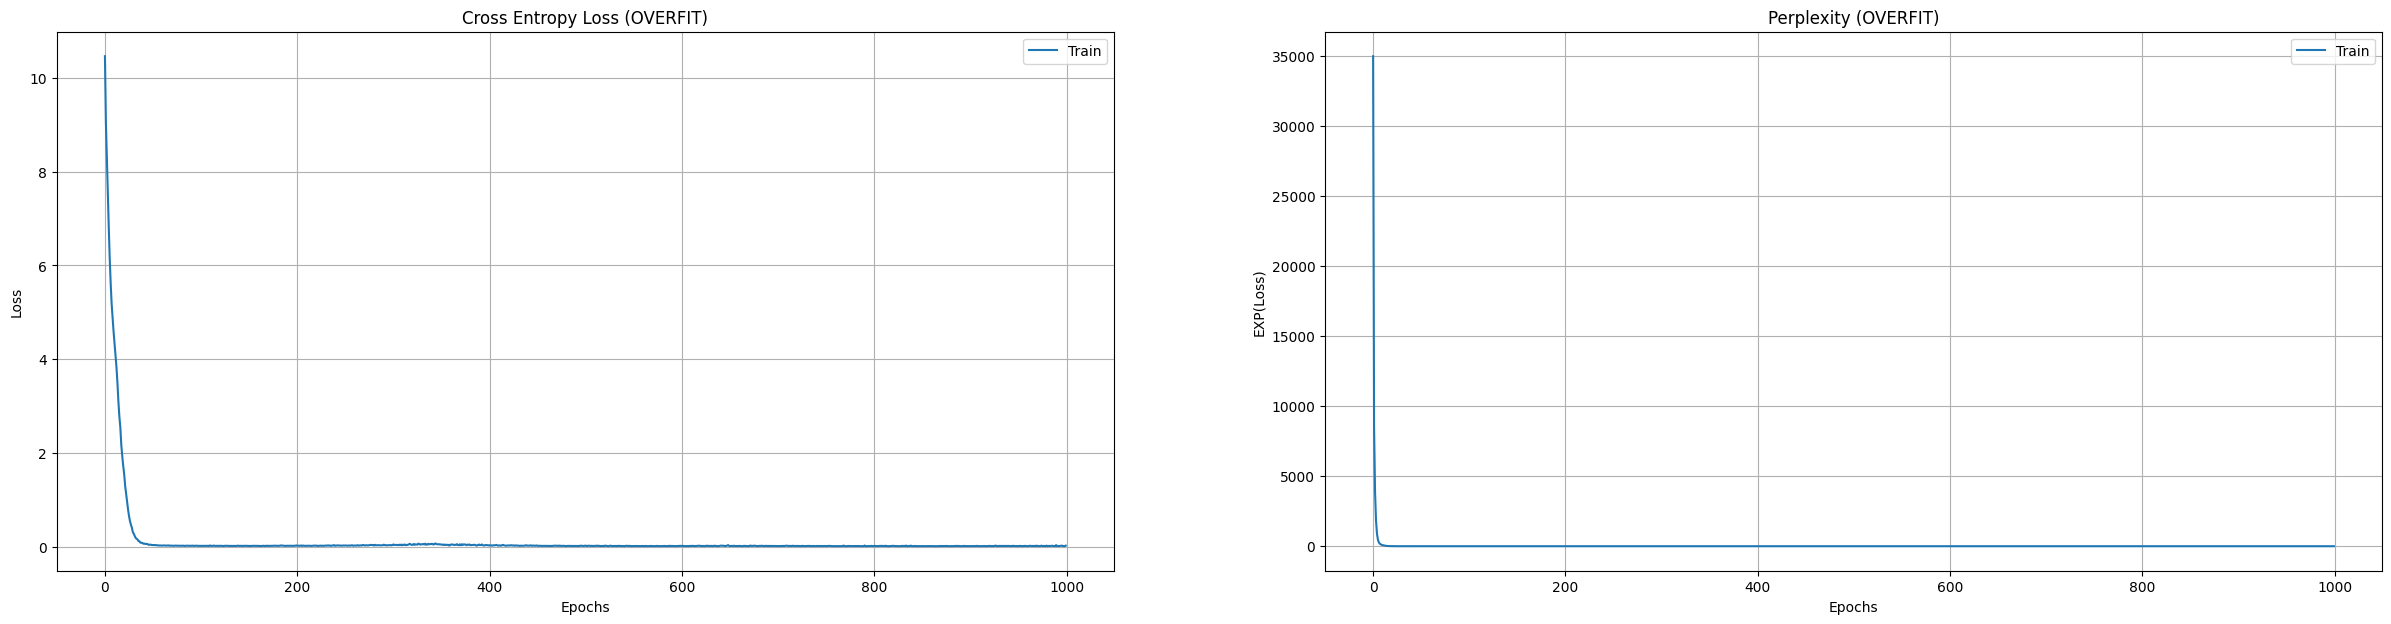

In [20]:
import matplotlib.pyplot as plt

steps = np.arange(len(history['train_loss']))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,7))
axes[0].plot(steps, history['train_loss'], label='Train')
axes[0].set_title('Cross Entropy Loss (OVERFIT)')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
axes[0].grid(); axes[0].legend()

axes[1].plot(steps, history['train_perplexity'], label='Train')
axes[1].set_title('Perplexity (OVERFIT)')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('EXP(Loss)')
axes[1].grid(); axes[1].legend()

print(f"Train Loss: {history['train_loss'][-1]} --- Train Perplexity: {history['train_perplexity'][-1]}")
plt.show()

### Training

In [21]:
model = LanguageModel(vocab_size=tokenizer.vocab_size, embedding_dim=params['embedding_dim'],
                      max_length=params['max_length'], num_heads=params['num_heads'])

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=params['lr'])
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=3, factor=0.9)
early_stopping = EarlyStopping(patience=params['patience'], min_delta=params['min_delta'])

history = {'train_loss': [], 'val_loss': [], 'train_perplexity': [], 'val_perplexity' : []}

for epoch in tqdm(range(0, params['epochs'])):
    
    train_loss = train_epoch(model=model, dataloader=train_loader, optimizer=optimizer, criterion=criterion)
    train_perplexity = np.exp(train_loss)
    
    val_loss = evaluate(model=model, dataloader=valid_loader, criterion=criterion)
    val_perplexity = np.exp(val_loss)
    
    scheduler.step(val_loss)    
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_perplexity'].append(train_perplexity)
    history['val_perplexity'].append(val_perplexity)
    
    if early_stopping(model, val_loss): break

  0%|          | 0/100 [00:00<?, ?it/s]

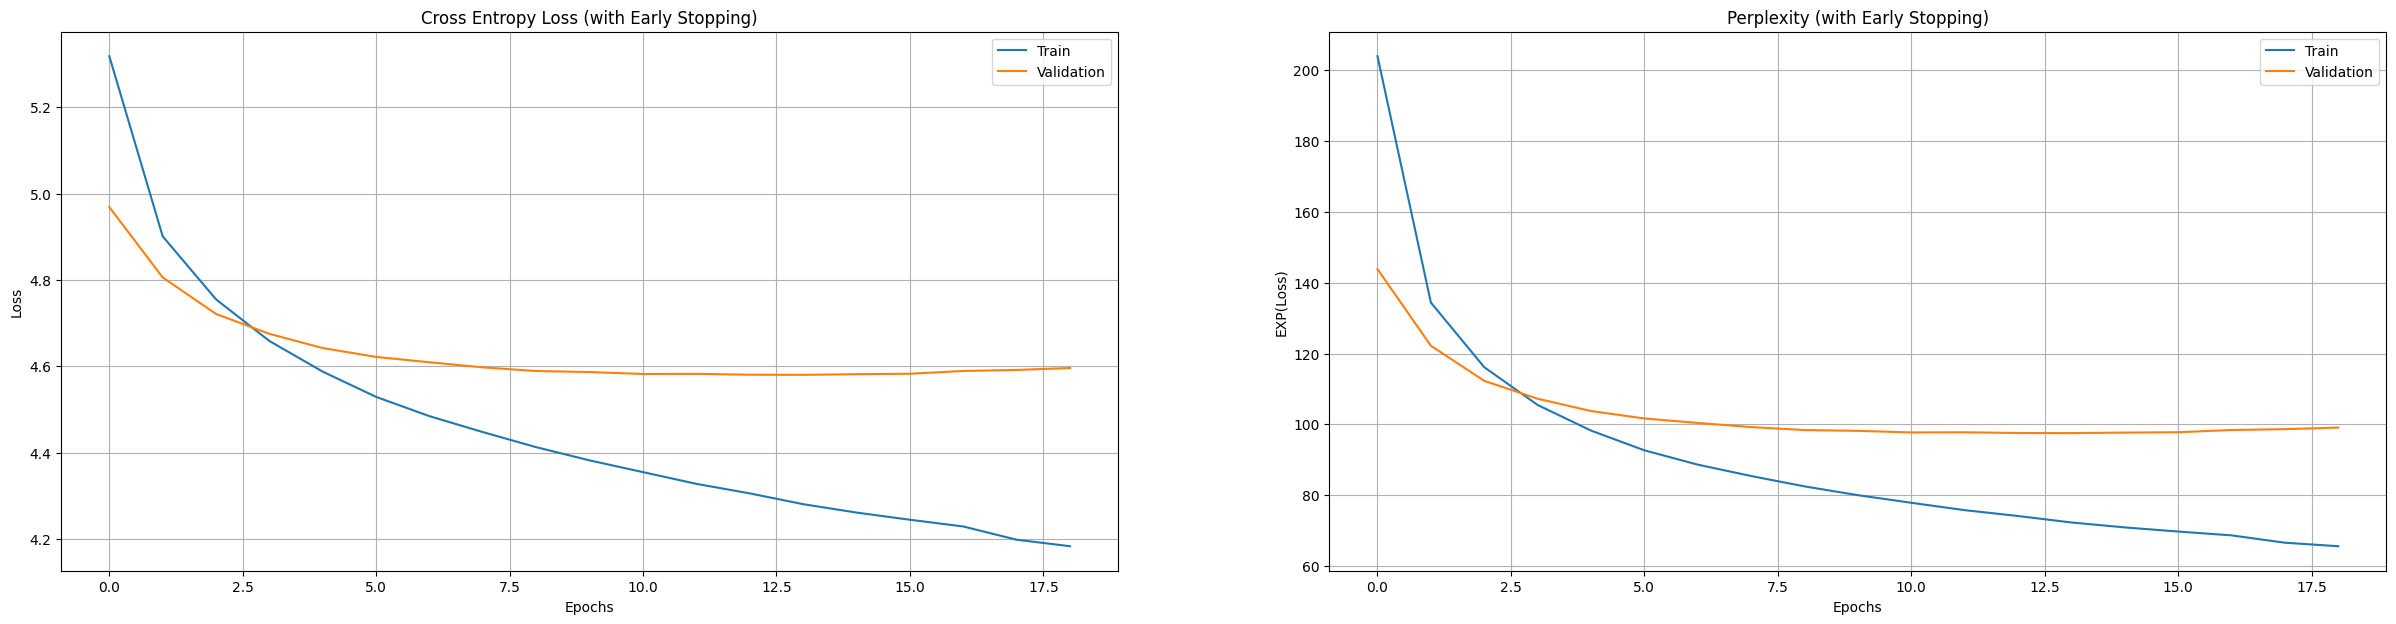

In [22]:
import matplotlib.pyplot as plt

epochs = np.arange(len(history['train_loss']))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,7))
axes[0].plot(epochs, history['train_loss'], label='Train')
axes[0].plot(epochs, history['val_loss'], label='Validation')
axes[0].set_title('Cross Entropy Loss (with Early Stopping)')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
axes[0].grid(); axes[0].legend()

axes[1].plot(epochs, history['train_perplexity'], label='Train')
axes[1].plot(epochs, history['val_perplexity'], label='Validation')
axes[1].set_title('Perplexity (with Early Stopping)')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('EXP(Loss)')
axes[1].grid(); axes[1].legend()

plt.show()

In [23]:
model = LanguageModel(vocab_size=tokenizer.vocab_size, embedding_dim=params['embedding_dim'],
                      max_length=params['max_length'], num_heads=params['num_heads'])

model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

test_loss = evaluate(model=model, dataloader=test_loader, criterion=criterion)
test_perplexity = np.exp(test_loss)

print(f'TEST LOSS: {test_loss} ----- TEST PERPLEXITY: {test_perplexity}')

TEST LOSS: 4.66858741229095 ----- TEST PERPLEXITY: 106.5471289153535


In [26]:
prompt = '[CLS] Amazing movie, good writer, terrific actors and '
max_output_tokens = 20

for _ in range(max_output_tokens):
    sample = tokenizer(f'{prompt}', return_tensors=None, add_special_tokens=False).input_ids
    sampled_tokenized = sample[-params['max_length']:]
    sampled_tokenized += [tokenizer.vocab['[PAD]']] * max(0, params['max_length'] - len(sampled_tokenized))

    inputs = torch.LongTensor(sampled_tokenized)[None, :].to(device)
    outputs = model(inputs)
    outputs = outputs[:,-1,:]
    
    predictions = torch.argmax(outputs).item()
    sample += [predictions]
    
    prompt = tokenizer.decode(sample)
    print(prompt)

[CLS] amazing movie, good writer, terrific actors and /
[CLS] amazing movie, good writer, terrific actors and / /
[CLS] amazing movie, good writer, terrific actors and / / or
[CLS] amazing movie, good writer, terrific actors and / / or or
[CLS] amazing movie, good writer, terrific actors and / / or or or
[CLS] amazing movie, good writer, terrific actors and / / or or or even
[CLS] amazing movie, good writer, terrific actors and / / or or or even a
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few of
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few of the
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few of the characters
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few of the characters,
[CLS] amazing movie, good writer, terrific actors and / / or or or even a few of the characters, and
[CLS] amaz